This notebook includes code to build and train model 1 (model with stacked LSTM encoder and 1-layer LSTM decoder with Bahdanau Attention)

I have consulted and adapted code from the following sources:
- A. Pai, “Text Summarization: Text Summarization Using Deep Learning”, 2020 Analytics Vidhya. [Online]. Available: https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/. [Accessed: 21-Apr-2021]. 
- “Neural machine translation with attention,” TensorFlow. [Online]. Available: https://www.tensorflow.org/tutorials/text/nmt_with_attention. [Accessed: 27-May-2021]. 

In [ ]:
import numpy as np  
import pandas as pd 
import tensorflow as tf
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import lxml
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_folder_path = "drive/MyDrive/Vassar/Junior Year/Spring/CMPU-366/Final Project"

In [ ]:
model_folder_name = "LSTM_model_onehot_128_latent_200_emb_128_batch_10_epochs"

In [ ]:
# !cp ./drive/MyDrive/Vassar/Junior\ Year/Spring/CMPU-366/Final\ Project/articles_signal_media_100k.json .
!cp ./drive/MyDrive/Vassar/Junior\ Year/Spring/CMPU-366/Final\ Project/articles.json .
!cp -r ./drive/MyDrive/Vassar/Junior\ Year/Spring/CMPU-366/Final\ Project/glove6B .

In [ ]:
!cp ./drive/MyDrive/Vassar/Junior\ Year/Spring/CMPU-366/Final\ Project/attention.py .


In [ ]:
from attention import AttentionLayer

In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('words')
words = set(nltk.corpus.words.words())

stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
# reference: https://www.tensorflow.org/tutorials/text/nmt_with_attention

# Converts the unicode file to ascii
import unicodedata

def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                 if unicodedata.category(c) != 'Mn')
  
def preprocess_text(text, is_article):
  text = unicode_to_ascii(text.lower().strip())

  # remove url
  text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "", text)

  # remove all words containing forward slashes and backslashes
  text = re.sub(r'\s*(?:[\w_]*[/\\](?:[\w_]*[/\\])*[\w_]*)', "", text)
  text = re.sub(u"(\u2018|\u2019)", "'", text) 
 
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  
  text = ' '.join([contraction_dict[t] if t in contraction_dict else t for t in text.split(" ")])    
  text = re.sub(r"([?.!,¿])", r" \1 ", text)
  text = re.sub(r'[" "]+', " ", text)

  text = re.sub(r"'s\b","",text)  
  
  text = text.replace("'", "")
  
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)

  if is_article:
    word_tokens = [word for word in text.split() if not word in stop_words]
  else: # not remove stop words from title
    word_tokens = text.split()

  processed_text_tokens = []
  for word_token in word_tokens:
    if len(word_token) > 1:
      processed_text_tokens.append(word_token)

  text = (" ".join(processed_text_tokens))
  text = text.strip()

  return text

In [ ]:
test_text = "The world\u2019s first throwable microphone"
print(preprocess_text(test_text, True))

world first throwable microphone


In [ ]:
article_list = []
title_list = []

import json 

with open('articles_2.json') as f:
  data = json.load(f)

for json_object in data:
  article = json_object['content']
  article = preprocess_text(article, is_article = True)
  article_list.append(article)

  title = json_object['title']
  title = preprocess_text(title, is_article = False)
  title = 'sostoken ' + title + ' eostoken'
  title_list.append(title)

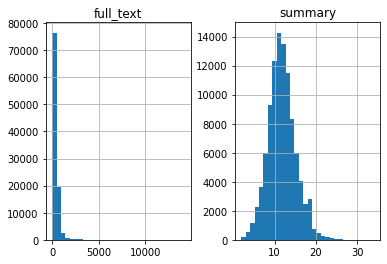

In [ ]:
import matplotlib.pyplot as plt
article_word_count = []
title_word_count = []

# populate the lists with sentence lengths
for article in article_list:
  article_word_count.append(len(article.split()))

for title in title_list:
  title_word_count.append(len(title.split()))

length_df = pd.DataFrame({'article': article_word_count, 'title':title_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
print(length_df['article'].values)

for i in range(0,100,10):
  article_lens = length_df['article'].values
  article_lens = np.sort(article_lens, axis = None)
  cur_percentile_len = article_lens[int(len(article_lens) * float(i)/100)]
  print("{} percentile full text length is {}".format(i, cur_percentile_len))

[ 500 2536 1292 ...   81  526 1043]
0 percentile full text length is 0
10 percentile full text length is 92
20 percentile full text length is 137
30 percentile full text length is 178
40 percentile full text length is 222
50 percentile full text length is 276
60 percentile full text length is 341
70 percentile full text length is 413
80 percentile full text length is 516
90 percentile full text length is 693


In [ ]:
max_len_article = 516
max_len_title = 25

Select the texts and title whose length is less than `max_len_article` and `max_len_title`

In [ ]:
min_len_article = 50
min_len_title = 5

In [ ]:
short_article_list = []
short_title_list = []
for i in range(len(article_list)):
  if (len(article_list[i].split()) <= min_len_article
          and len(title_list[i].split()) <= min_len_title):
    continue
  if (len(article_list[i].split()) <= max_len_article
          and len(title_list[i].split()) <= max_len_title):
    short_article_list.append(article_list[i])
    short_title_list.append(title_list[i])


In [ ]:
df = pd.DataFrame({'article': short_article_list, 'title': short_title_list}) 
df['title']

0                            sostoken house republicans fret about winning their health care suit eostoken
1                                                                               sostoken kim jong eostoken
2                                 sostoken sick with cold queen elizabeth misses new year service eostoken
3                                 sostoken taiwan president accuses china of renewed intimidation eostoken
4                                     sostoken calling on angels while enduring the trials of job eostoken
                                                       ...                                                
79711    sostoken novak djokovic loses cool and shanghai semi final against roberto bautista agut eostoken
79712                 sostoken miss black and beautiful the pageants where curves and afros ruled eostoken
79713                 sostoken if baltimore is serious about police reform give citizens more say eostoken
79714                       sostoken 

In [ ]:
print(len(article_list), len(title_list))
print(len(short_article_list), len(short_title_list))

99999 99999
79716 79716


# Tokenize

In [ ]:
def tokenize(text_train, text_validate, max_len_text):
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(list(text_train))

    #convert text sequences into integer sequences
    text_train = text_tokenizer.texts_to_sequences(text_train)
    text_validate = text_tokenizer.texts_to_sequences(text_validate)

    # max_len_text = max(len(text) for text in text_train)

    #padding zero upto maximum length
    text_train = pad_sequences(text_train, maxlen=max_len_text, padding='post')
    text_validate = pad_sequences(text_validate, maxlen=max_len_text, padding='post')

    text_vocab_size = len(text_tokenizer.word_index) + 1

    return text_tokenizer, text_train, text_validate, text_vocab_size


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate=train_test_split(np.array(df['article']),np.array(df['title']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
# Tokenize full text
x_tokenizer, x_train, x_validate, x_vocab_size = tokenize(x_train, x_validate, max_len_article)

% of rare words:  60.324031757979824


In [ ]:
x_vocab_size

167392

In [ ]:
# Tokenize title
y_tokenizer, y_train, y_validate, y_vocab_size = tokenize(y_train, y_validate, max_len_title)

% of rare words:  63.277888382249046


In [ ]:
y_vocab_size

31143

In [ ]:
y_tokenizer.word_counts['sostoken'],len(y_train)

(71744, 71744)

Delete the rows that only contains the `<start>` and `<end>` token

In [ ]:
def get_rows_with_only_start_end(data):
    indices = []

    for i in range(len(data)):
        count = 0
        for j in data[i]:
            if j != 0:
                count += 1
        if count == 2:
            indices.append(i)
            
    return indices
    

In [ ]:
train_row_with_only_start_end = get_rows_with_only_start_end(y_train)

y_train = np.delete(y_train, train_row_with_only_start_end, axis=0)
x_train = np.delete(x_train, train_row_with_only_start_end, axis=0)

In [ ]:
validate_row_with_only_start_end = get_rows_with_only_start_end(y_validate)

y_validate = np.delete(y_validate, validate_row_with_only_start_end, axis=0)
x_validate = np.delete(x_validate, validate_row_with_only_start_end, axis=0)

In [ ]:
np.save("{}/training_data_nd_array/{}/x_train.npy".format(drive_folder_path, model_folder_name), x_train)
np.save("{}/training_data_nd_array/{}/y_train.npy".format(drive_folder_path, model_folder_name), y_train)

# Build Model

In [ ]:
from keras import backend as K

K.clear_session()

latent_dim = 128
embedding_dim = 200

# define encoder input
encoder_inputs = Input(shape=(max_len_article, ))

# define encoder embedding layer
encoder_embedding_layer = Embedding(x_vocab_size, embedding_dim, trainable=True)
encoder_embedding = encoder_embedding_layer(encoder_inputs)

# define 1st encoder lstm layer
encoder_lstm_1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout = 0.2)
encoder_output_1, state_h1, state_c1 = encoder_lstm_1(encoder_embedding)

# define 2nd encoder lstm layer
encoder_lstm_2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout = 0.2)
encoder_output_2, state_h2, state_c2 = encoder_lstm_2(encoder_output_1)

# define 3rd encoder lstm layer
encoder_lstm_3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout = 0.2)
encoder_outputs, state_h, state_c = encoder_lstm_3(encoder_output_2)

# define decoder input 
decoder_inputs = Input(shape=(None, ))

# define decoder embedding layer
decoder_embedding_layer = Embedding(y_vocab_size, embedding_dim, trainable=True)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

# define decoder lstm layer
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout = 0.2)
decoder_input_states = [state_h, state_c]
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, decoder_input_states)

# implement the Attention layer
attention_layer = AttentionLayer(name='attention_layer')
attention_input_states = [encoder_outputs, decoder_outputs]
attention_output, attention_states = attention_layer(attention_input_states)

# attention_layer = tf.keras.layers.AdditiveAttention()
# attention_output = attention_layer(attention_input_states)
# print(attention_output)
# print(decoder_outputs)

# define concatenate layer
concatenate_layer = Concatenate(axis=-1, name='concat_layer')

# define layer of concatenated attention output and decoder lstm outputs
decoder_concatenated_layer = concatenate_layer([decoder_outputs, attention_output])

# define the dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concatenated_layer)

# define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 516)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 516, 200)     33478400    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 516, 128), ( 168448      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
decoder_dense

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min', patience=2, verbose=1)

In [ ]:
history = model.fit(
    x = [x_train, y_train[:, :-1]],
    y = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
    epochs = 15,
    callbacks=[early_stopping],
    batch_size = 128,
    validation_data=([x_validate,y_validate[:,:-1]], y_validate.reshape(y_validate.shape[0],y_validate.shape[1], 1)[:,1:])
  )

Epoch 1/15
561/561 [==============================] - 3331s 6s/step - loss: 3.2796 - accuracy: 0.5930 - val_loss: 3.0372 - val_accuracy: 0.6089
Epoch 2/15
561/561 [==============================] - 3317s 6s/step - loss: 3.0331 - accuracy: 0.6093 - val_loss: 2.8957 - val_accuracy: 0.6189
Epoch 3/15
561/561 [==============================] - 3370s 6s/step - loss: 2.8839 - accuracy: 0.6196 - val_loss: 2.7804 - val_accuracy: 0.6274
Epoch 4/15
561/561 [==============================] - 3462s 6s/step - loss: 2.7772 - accuracy: 0.6276 - val_loss: 2.7107 - val_accuracy: 0.6332
Epoch 5/15
561/561 [==============================] - 3466s 6s/step - loss: 2.6976 - accuracy: 0.6340 - val_loss: 2.6579 - val_accuracy: 0.6384
Epoch 6/15
561/561 [==============================] - 3403s 6s/step - loss: 2.6317 - accuracy: 0.6396 - val_loss: 2.6211 - val_accuracy: 0.6415
Epoch 7/15
561/561 [==============================] - 3430s 6s/step - loss: 2.5757 - accuracy: 0.6440 - val_loss: 2.5871 - val_accuracy:

In [ ]:
df_history = pd.DataFrame(history.history)

# or save to csv: 
history_csv_file = "{}/history/{}.csv".format(drive_folder_path, model_folder_name)

with open(history_csv_file, mode='w') as csv_file:
    df_history.to_csv(csv_file)

In [ ]:
model.save("drive/MyDrive/Vassar/Junior Year/Spring/CMPU-366/Final Project/model/{}".format(model_folder_name))

INFO:tensorflow:Assets written to: drive/MyDrive/Vassar/Junior Year/Spring/CMPU-366/Final Project/model/LSTM_model_onehot_128_latent_200_emb_128_batch_10_epochs/assets


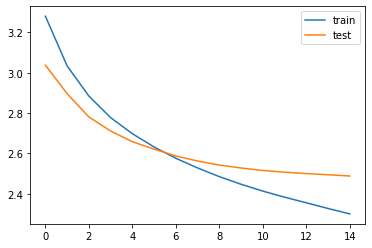

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

{1: 'sostoken', 2: 'eostoken', 3: 'to', 4: 'the', 5: 'in', 6: 'trump', 7: 'breitbart', 8: 'of', 9: 'for', 10: 'is', 11: 'on', 12: 'and', 13: 'not', 14: 'with', 15: 'at', 16: 'clinton', 17: 'after', 18: 'new', 19: 'are', 20: 'will', 21: 'from', 22: 'it', 23: 'as', 24: 'donald', 25: 'hillary', 26: 'be', 27: 'obama', 28: 'over', 29: 'by', 30: 'this', 31: 'about', 32: 'says', 33: 'you', 34: 'that', 35: 'his', 36: 'us', 37: 'out', 38: 'how', 39: 'have', 40: 'was', 41: 'has', 42: 'he', 43: 'up', 44: 'who', 45: 'what', 46: 'why', 47: 'house', 48: 'man', 49: 'police', 50: 'an', 51: 'we', 52: 'gop', 53: 'no', 54: 'more', 55: 'white', 56: 'state', 57: 'do', 58: 'bill', 59: 'president', 60: 'report', 61: 'people', 62: 'your', 63: 'news', 64: 'first', 65: 'could', 66: 'one', 67: 'year', 68: 'cruz', 69: 'just', 70: 'against', 71: 'her', 72: 'campaign', 73: 'can', 74: 'into', 75: 'attack', 76: 'if', 77: 'america', 78: 'should', 79: 'off', 80: 'anti', 81: 'all', 82: 'get', 83: 'than', 84: 'woman', 85

In [ ]:
import json

# save word index dictionaries
json.dump(reverse_target_word_index, open( "{}/word_idx_dict/{}/reverse_target_word_index.json".format(drive_folder_path, model_folder_name), 'w' ) )
json.dump(reverse_source_word_index, open( "{}/word_idx_dict/{}/reverse_source_word_index.json".format(drive_folder_path, model_folder_name), 'w' ) )
json.dump(target_word_index, open( "{}/word_idx_dict/{}/target_word_index.json".format(drive_folder_path, model_folder_name), 'w' ) )
